## Анализ временного ряда продаж лекарств от диабета и прогноз на год вперед
### Выполнил: Земнухов Вадим

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)

In [41]:
import statsmodels.api as sm 
from scipy.special import inv_boxcox
from itertools import product
import warnings
import scipy.stats as sps

В файле `anti-diabetic-drugs.csv` содержатся данные о ежемесячных продажах антидиабетических препаратов в Австралии с 1992 по 2008 год. 

Проанализируем этот ряд и построим модель SARIMA, чтобы сделать прогноз на 1 год вперед.

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


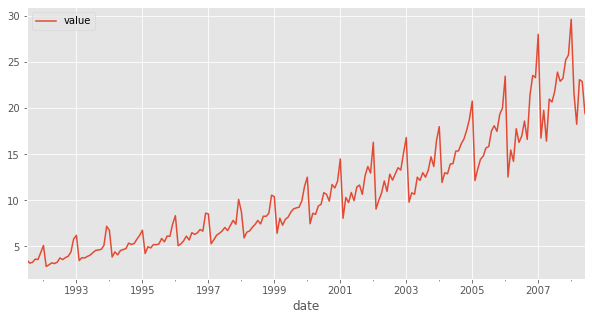

In [42]:
df = pd.read_csv('anti-diabetic-drugs.csv', index_col='date', parse_dates=['date'])
df.plot();
df.head()

In [43]:
df['value'].isnull().sum()

0

По данному графику можно сказать, что временной ряд имеет тренд (не является стационарным), а также обладает свойством сезонности. Для анализа данного ряда его нужно будет дифференцировать, чтобы сделать стационарным. Дисперсия на первый взгляд кажется вполне приемлемой, но определнные подозрения вызывает увеличение амплитуды сезонности с течением времени. Сделаем преобразование Бокса Кокса и проверим, что изменилось. При необходимости сделаем обратное преобразование.

In [44]:
df['value_boxcox'], lmbd = sps.boxcox(df['value'])

In [45]:
print("Оптимальный параметр преобразования Бокса-Кокса: ",lmbd)

Оптимальный параметр преобразования Бокса-Кокса:  0.061505584870954325


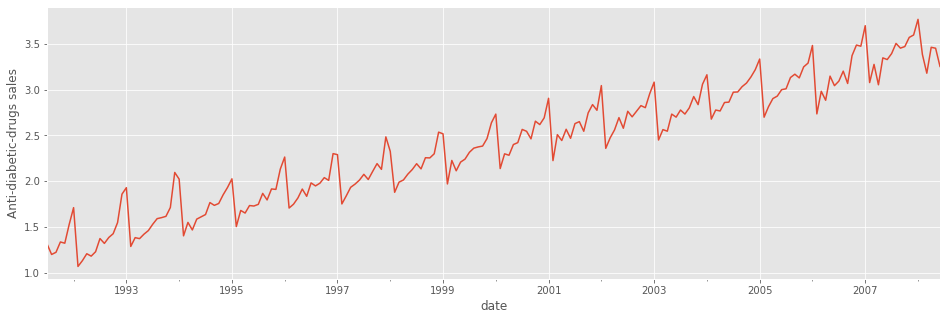

In [46]:
plt.figure(figsize=(16,5))
df['value_boxcox'].plot()
plt.ylabel('Anti-diabetic-drugs sales')
plt.show()

Дисперсия стала более стабильной. Будем работать с рядом после преобразования Бокса-Кокса.

Теперь выполним STL-декомпозицию ряда.

<Figure size 1152x576 with 0 Axes>

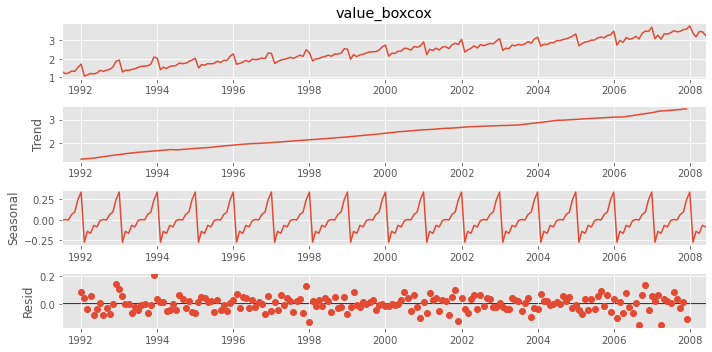

In [47]:
plt.figure(figsize=(16,8))
sm.tsa.seasonal_decompose(df['value_boxcox']).plot()
plt.show();

По построенным графикам видно наличие тренда и сезонности. 

Гипотезу об отсутствии тренда проверим критерием Дикки-Фулера на уровне значимости 5%.

In [48]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",
      sm.tsa.stattools.adfuller(df['value_boxcox'])[1])

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 0.8751832090757105


Гипотеза о нестационарности ряда не отвергается на уровне значимости 5%. Следовательно ряд нужно дифференцировать для использования модели SARIMA.

In [49]:
df['value_boxcox_diff'] = df['value_boxcox'] - df['value_boxcox'].shift(12)

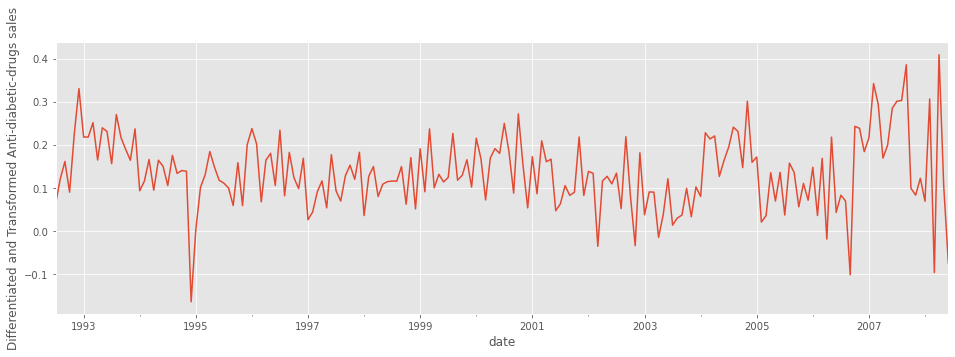

In [50]:
plt.figure(figsize=(16,5))
df['value_boxcox_diff'][12:].plot()
plt.ylabel('Differentiated and Transformed Anti-diabetic-drugs sales')
plt.show()

<Figure size 1152x576 with 0 Axes>

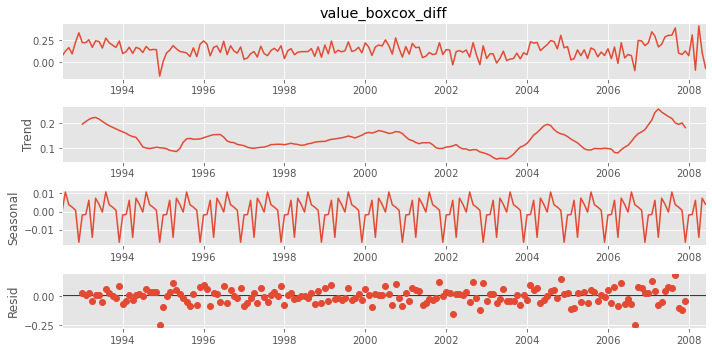

In [51]:
plt.figure(figsize=(16,8))
sm.tsa.seasonal_decompose(df['value_boxcox_diff'][12:]).plot()
plt.show();

Видим, что после сезонного дифференцирования пропала только сезонность, но ряд не стал стационарным  например, т.к. у него есть заметный тренд. Сделаем еще одно обычное дифференцирование.

In [52]:
df['value_boxcox_diff_2'] = df['value_boxcox_diff'] - df['value_boxcox_diff'].shift(1)

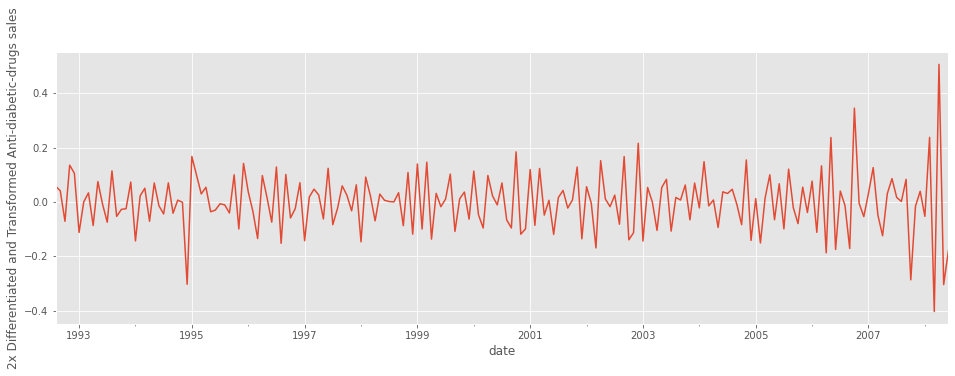

In [53]:
plt.figure(figsize=(16,5))
df['value_boxcox_diff_2'][13:].plot()
plt.ylabel('2х Differentiated and Transformed Anti-diabetic-drugs sales')
plt.show()

<Figure size 1152x576 with 0 Axes>

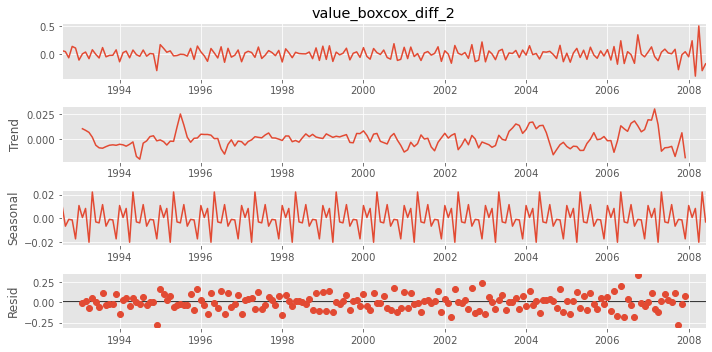

In [54]:
plt.figure(figsize=(16,8))
sm.tsa.seasonal_decompose(df['value_boxcox_diff_2'][13:]).plot()
plt.show();

In [55]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",
      sm.tsa.stattools.adfuller(df['value_boxcox_diff_2'][13:])[1])

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 5.299278344681013e-05


Гипотеза о нестационарности ряда отвергается на уровне значимости 5%.

Теперь проанализируем параметры автокорреляционной функции ACF и частичной автокорреляционной функции PACF.

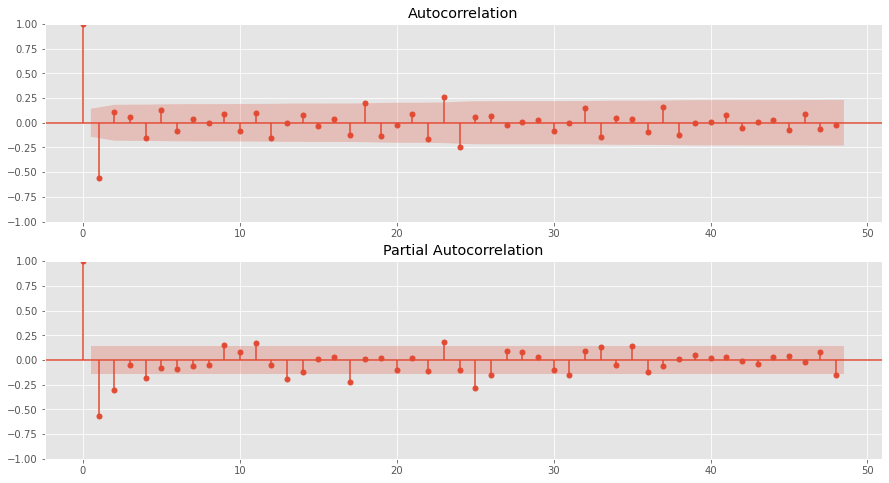

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(df['value_boxcox_diff_2'][13:].values.squeeze(), lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(df['value_boxcox_diff_2'][13:].values.squeeze(), lags=48, ax=ax2)

plt.show();

Согласно этим графикам, в качестве начальных значений необходимо взять: $Q=0$, $q=1$, $P=0$, $p=2$. Но так как у нас немного факторов + смушает наличие чередующегося значимого лага у частной автокорреляции. Поэтому как бейзлайн возьмём $P=2$.

In [57]:
s = 12
d = 1
D = 1
ps = range(0, 2+1)
qs = range(0, 1+1)

Ps = range(0, 2+1)
Qs = range(0, 0+1)

parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

parameters_list[:10]

[(0, 0, 0, 0),
 (0, 0, 1, 0),
 (0, 0, 2, 0),
 (0, 1, 0, 0),
 (0, 1, 1, 0),
 (0, 1, 2, 0),
 (1, 0, 0, 0),
 (1, 0, 1, 0),
 (1, 0, 2, 0),
 (1, 1, 0, 0)]

In [58]:
len(parameters_list)

18

In [59]:
p=q=Q=P=1

odel=sm.tsa.statespace.SARIMAX(df['value_boxcox'],
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s))

In [60]:
odel.fit()

In [61]:
from tqdm.notebook import tqdm

results = []
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    p, q, P, Q = param
    try:
        model=sm.tsa.statespace.SARIMAX(df['value_boxcox'],
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s)).fit(disp=-1)
    
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

  0%|          | 0/18 [00:00<?, ?it/s]

In [62]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']

In [63]:
result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
14,"(2, 0, 2, 0)",-444.264810
11,"(1, 1, 2, 0)",-444.087484
17,"(2, 1, 2, 0)",-442.265125
5,"(0, 1, 2, 0)",-438.558896
10,"(1, 1, 1, 0)",-419.830628


Наилучшей моделью оказалась модель с параметрами (2, 1, 0)х(2, 1, 0, 12)

In [64]:
best_model = sm.tsa.statespace.SARIMAX(df['value_boxcox'], 
                                     order=(2,1,0), 
                                     seasonal_order=(2,1,0,12)).fit(disp=-1)

In [65]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       value_boxcox   No. Observations:                  204
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 227.132
Date:                            Wed, 22 Feb 2023   AIC                           -444.265
Time:                                    16:48:11   BIC                           -428.003
Sample:                                07-01-1991   HQIC                          -437.678
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9204      0.059    -15.482      0.000      -1.037      -0.804
ar.L2         -0.4883      0.061   

Чтобы убедиться, что модель хорошая проанализируем остатки. В данном summary также заметить, что критерий Льюнга-Бокса не отвергает гипотезу о независимости остатков.

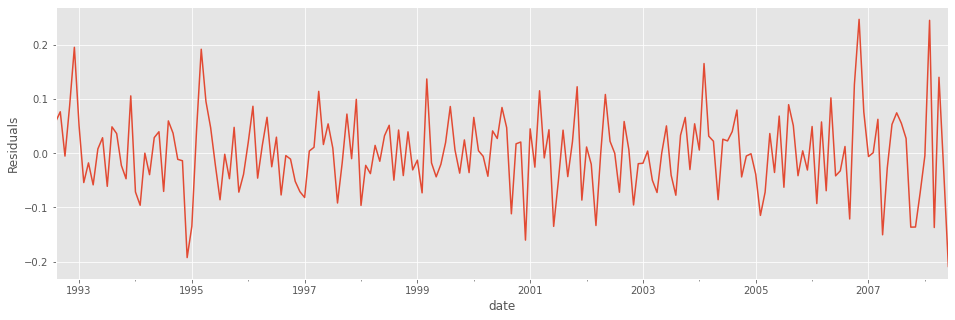

In [66]:
plt.figure(figsize=(16,5))
best_model.resid[13:].plot()
plt.ylabel('Residuals')
plt.show()

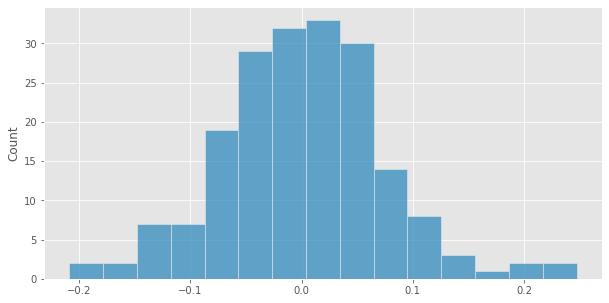

In [67]:
sns.histplot(best_model.resid[13:]);

Визуально остатки выглядят хорошо. Не видны признаки смещенности, нестационарности или какой-либо зависимости.

**Несмещенность.** Проверим несмещенность с помощью критерия знаков.

In [68]:
from statsmodels.stats.descriptivestats import sign_test
print("Критерий знаков для остатков: pvalue =",
      sign_test(best_model.resid[13:])[1])

Критерий знаков для остатков: pvalue = 1.0


Гипотеза о несмещенности не отвергается.

**Стационарность.** Проверим стационарность с помщью критерия Дики-Фуллера.

In [69]:
print("Критерий Дики-Фуллера для остатков: pvalue =",
      sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Дики-Фуллера для остатков: pvalue = 5.846060696093496e-16


Гипотеза о нестационарности не отвергается.

**Неавтокоррелированность.** Чтобы определить независимость остатков, посмотрим на график автокорреляционной функции.

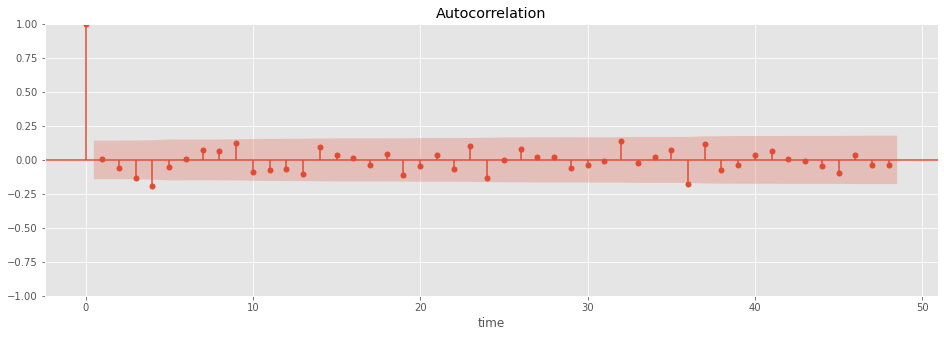

In [70]:
fig, ax = plt.subplots(figsize=(16,5))
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
ax.set_xlabel('time')
plt.show()

По данному графику можно сказать, что остатки по большей части независимы. Теперь попробуем построить прогноз на год вперед.

In [71]:
df['model'] = inv_boxcox(best_model.fittedvalues, lmbd)

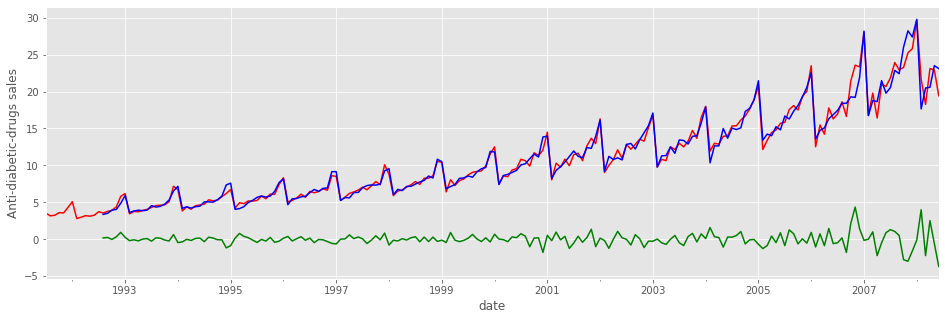

In [72]:
plt.figure(figsize=(16,5))
df['value'].plot(color='r')
df['model'][13:].plot(color='b')


(df['value']-df['model'][13:]).plot(color='g')



plt.ylabel('Anti-diabetic-drugs sales')
plt.show();

In [73]:
df.tail(5)

,value,value_boxcox,value_boxcox_diff,value_boxcox_diff_2,model
date,,,,,
2008-02-01,21.654285,3.385265,0.306853,0.237492,17.651288
2008-03-01,18.264945,3.180677,-0.096285,-0.403139,20.473478
2008-04-01,23.107677,3.463910,0.409604,0.505889,20.575915
2008-05-01,22.912510,3.453623,0.105350,-0.304254,23.503773
2008-06-01,19.431740,3.254856,-0.074925,-0.180274,23.103182


In [74]:
import datetime
from dateutil.relativedelta import relativedelta

plot_data = df[['value','model']]

date_list = [datetime.datetime.strptime("2008-06-01", "%Y-%m-%d") + relativedelta(months=x) 
             for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= plot_data.columns)
plot_data = pd.concat([plot_data, future])

plot_data.tail()

,value,model
2009-01-01,NaN,NaN
2009-02-01,NaN,NaN
2009-03-01,NaN,NaN
2009-04-01,NaN,NaN
2009-05-01,NaN,NaN


In [75]:
start = df.shape[0]
start

204

In [76]:
forecast = inv_boxcox(best_model.predict(start=start, end=start+11), lmbd)
forecast.index = date_list

In [77]:
plot_data.loc[date_list, 'model'] = forecast

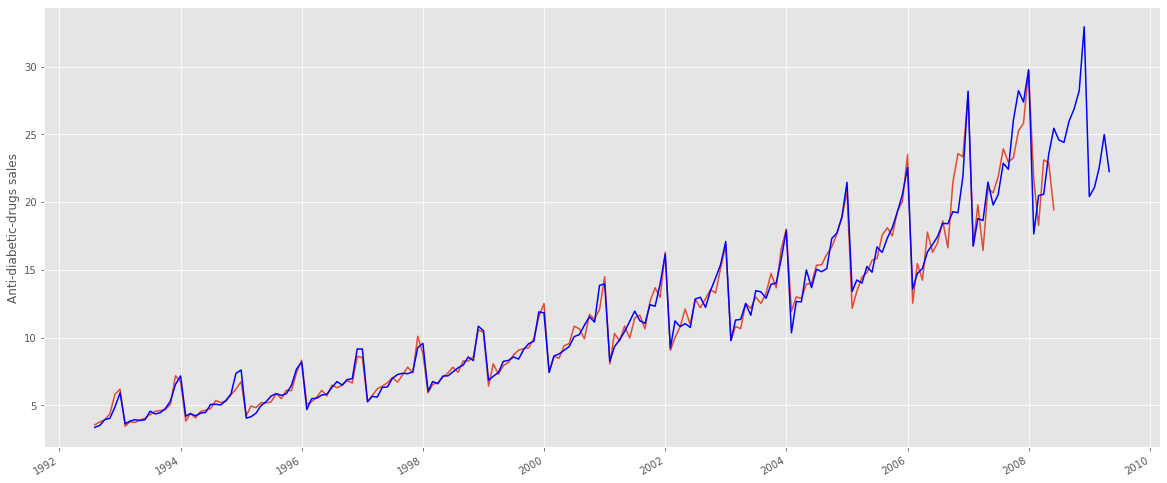

In [78]:
plt.figure(figsize=(20,9))
plot_data['value'][13:].plot()
plot_data['model'][13:].plot(color='b')
plt.ylabel('Anti-diabetic-drugs sales')
plt.show();